In [1]:
!pip install --upgrade joblib==1.1.0
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt -qq -y install fonts-nanum > /dev/null

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

sns.set_theme(style="darkgrid")

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
fm._rebuild()  


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
import mglearn
from sklearn.model_selection import train_test_split

# 앙상블
> 여러 머신러닝 모델을 결합하여 성능을 향상시키는 것    
- Bagging : varience를 감소시키는 역할
- Boosting : bias를 감소시키는 역할

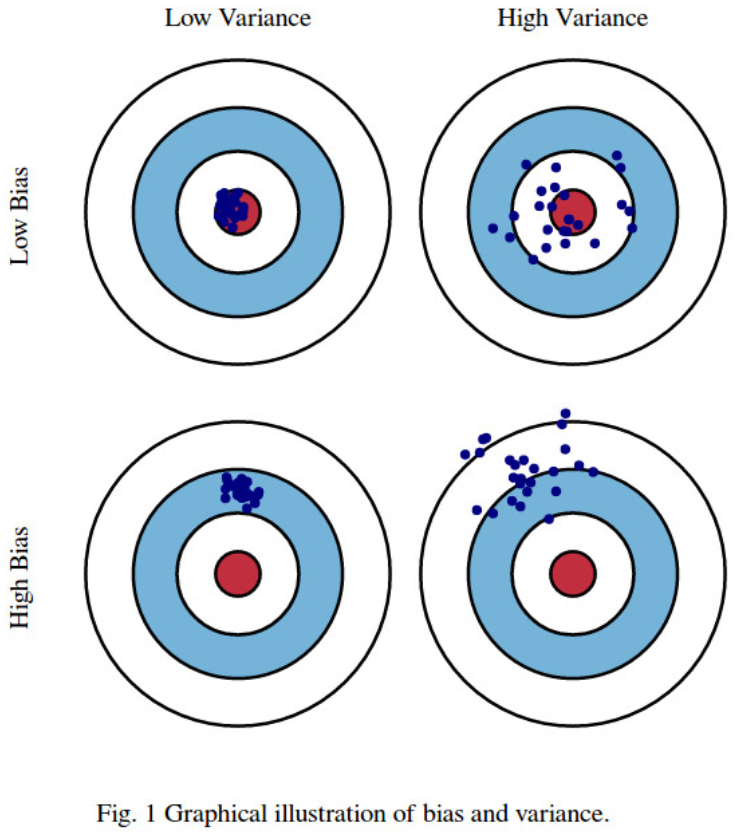

## bagging
1. 데이터로부터 복원추출을 통해 n개의 bootstrap sample 생성
2. 해당 sample 학습
3. 1, 2 과정을 M번 반복한 후 최종 모델 정의

- 겹칠 수는 있어도 완전히 같지는 않는다. 
- 서로 다른 sample로 학습해서 결과값이 다르다.

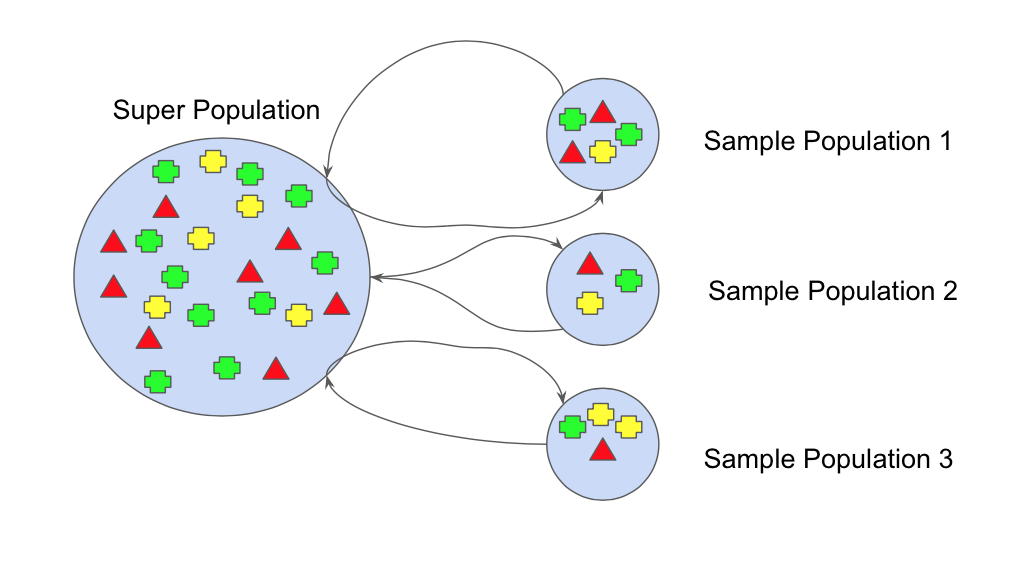

### Random Forest
> overfitting을 조합해서 제거한다는 강점이 있다.
- n_estimators : 생성할 트리의 개수
- max_features : 각 트리가 얼마나 무작위가 될지 결정하여 작을 수록 과대적합을 줄여준다. (일반적으로 기본값 추천)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

In [5]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=0)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
forest = RandomForestClassifier(n_estimators=6, random_state=2).fit(X_tr, y_tr)

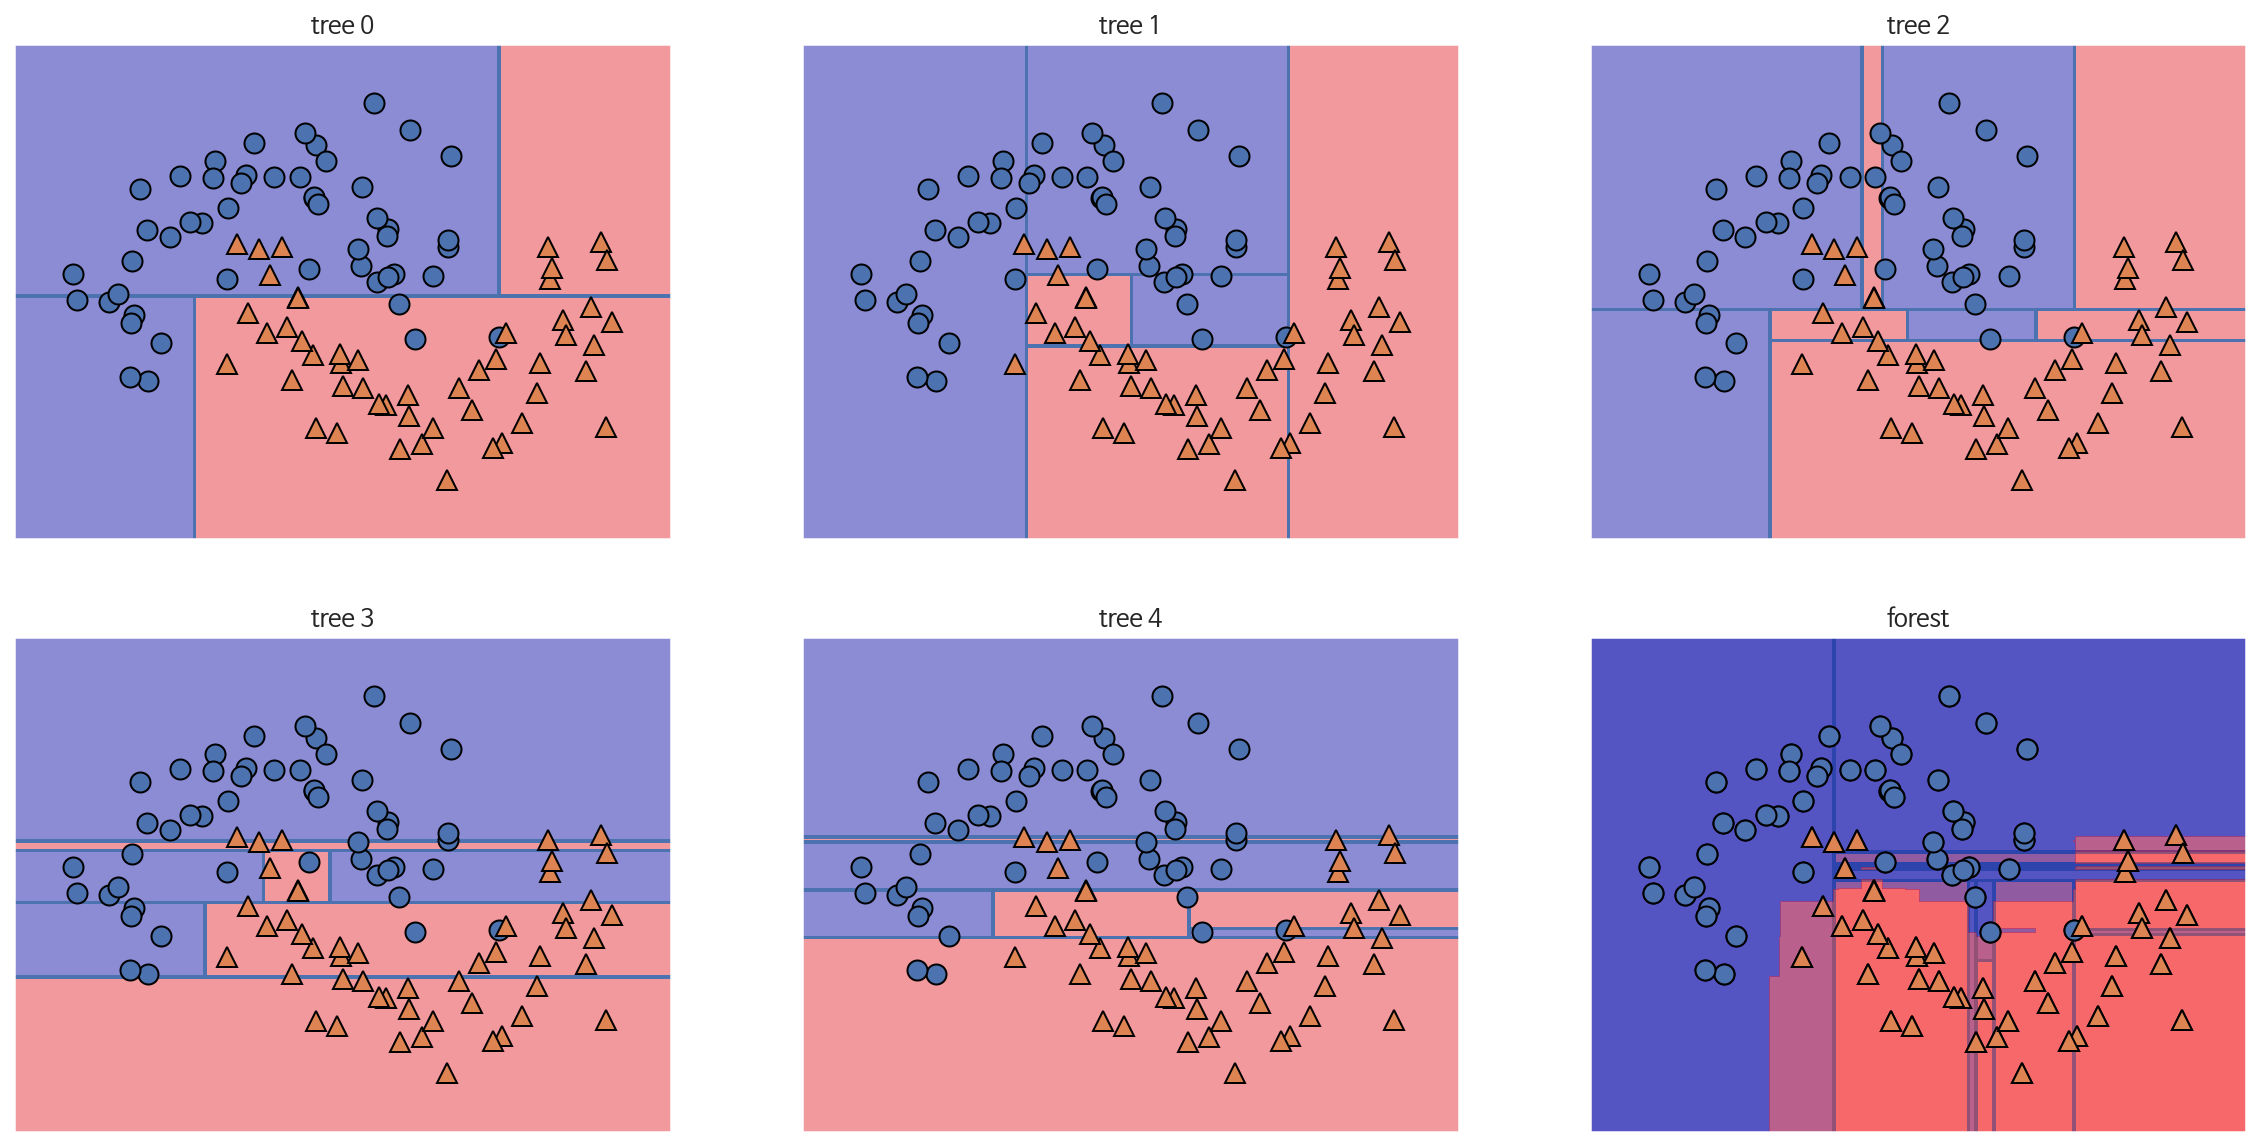

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20,10)) 

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
  ax.set_title(f"tree {i}")
  mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1,-1], alpha=0.4) 
axes[-1,-1].set_title("forest")
mglearn.discrete_scatter(X[:,0], X[:,1], y)

In [8]:
from sklearn.datasets import load_breast_cancer

In [9]:
cancer = load_breast_cancer()
X_tr, X_te, y_tr, y_te = train_test_split(
      cancer.data, cancer.target, stratify=cancer.target, random_state=42
)

In [10]:
forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {forest.score(X_tr, y_tr)} / 테스트용 평가지표 : {forest.score(X_te, y_te)}')

훈련용 평가지표 : 1.0 / 테스트용 평가지표 : 0.958041958041958


훈련용 평가지표가 오버피팅이 되었음을 알 수 있다.  (tree의 수가 너무 많음)      
하이퍼 파라미터 지정 필요

In [11]:
hp = {
    'random_state' : 0,
    'max_features' : 'sqrt',
    'n_estimators' : 100,
    'max_depth' : 10, 
    'min_samples_split' : 10,
    'min_samples_leaf' : 3
}

In [12]:
# 오버피팅이 줄어든 것을 알 수 있다. 
forest = RandomForestClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {forest.score(X_tr, y_tr)} / 테스트용 평가지표 : {forest.score(X_te, y_te)}')

훈련용 평가지표 : 0.9882629107981221 / 테스트용 평가지표 : 0.958041958041958


## Boosting
1. weak learner를 생성한 후 error 계산
2. error에 기여한 sample마다 다른 가중치를 두고 해당 error를 감소시키는 새로운 모델 학습
3. 1, 2 과정을 M번 반복한 후 최종 Boosting 모델을 정의

- bagging은 독립적이라는 것에서 차이가 있다.
- 모델이 전체 데이터를 학습한다는 장점이 있다. 
- bagging보다 효과가 좋다.

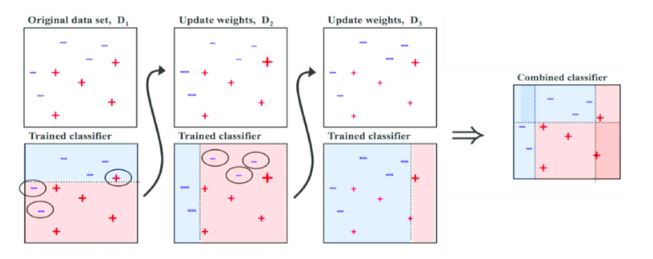

### Gradient Boost
- 보통 max_depth를 1~5 이하로 설정하여 약한 트리들을 만들어 학습하는 트리 기반 부스팅 앙상블 모델
- 머신러닝 알고리즘 중에서 가장 예측 성능이 높다고 알려졌고 인기 있는 알고리즘      

> 주요 파라미터            
- max_depth : 1~5 이하로 설정
- n_estimators : 생성할 트리의 개수
- learning_rate : 얼마나 강하게 보정할건지 정하는 수치

In [13]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [14]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_tr, X_te, y_tr, y_te = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

In [15]:
gradient = GradientBoostingRegressor(random_state=42).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {gradient.score(X_tr, y_tr)} / 테스트용 평가지표 : {gradient.score(X_te, y_te)}')

훈련용 평가지표 : 0.9954470985502689 / 테스트용 평가지표 : 0.8460598376785138


상기 모델은 오버피팅이 되었으므로 하이퍼 파라미터 적용 필요

In [16]:
hp = {
    'max_depth' : 1,
    'n_estimators' : 100,
    'random_state' : 0
}

In [17]:
gradient = GradientBoostingRegressor(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {gradient.score(X_tr, y_tr)} / 테스트용 평가지표 : {gradient.score(X_te, y_te)}')

훈련용 평가지표 : 0.8864176486236018 / 테스트용 평가지표 : 0.8290914723510503


In [18]:
# learning rate는 학습의 정도를 결정하는 중요한 요소 

hp = {
    'random_state' : 0,
    'max_depth' : 1,
    'n_estimators' : 100,
    'learning_rate' : 0.2
}

In [19]:
gradient = GradientBoostingRegressor(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {gradient.score(X_tr, y_tr)} / 테스트용 평가지표 : {gradient.score(X_te, y_te)}')

훈련용 평가지표 : 0.9030424533281206 / 테스트용 평가지표 : 0.8335348874914779


### XG Boost
- 병렬 구조, GBM보다 빠르다.

In [20]:
from xgboost import XGBClassifier, plot_importance

hp = {
    "random_state" : 42
}

xgb = XGBClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {xgb.score(X_tr, y_tr)} / 테스트용 평가지표 : {xgb.score(X_te, y_te)}')

훈련용 평가지표 : 1.0 / 테스트용 평가지표 : 0.951048951048951


> 과적합 방지

- learning rate 낮추기, n_estimate 높이기
- max_depth 낮추기
- min_child_weight 높이기
- gamma 높이기

In [21]:
hp = {
    'random_state' : 42,
    'max_depth' : 2,
    'n_estimators' : 200, # 수행할 부스팅 단계 수'
    'learning_rate' : 0.01,
    'min_child_weight' : 2,
    'gamma' : 1
}

In [22]:
xgb = XGBClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {xgb.score(X_tr, y_tr)} / 테스트용 평가지 표 : {xgb.score(X_te, y_te)}')

훈련용 평가지표 : 0.9812206572769953 / 테스트용 평가지 표 : 0.951048951048951


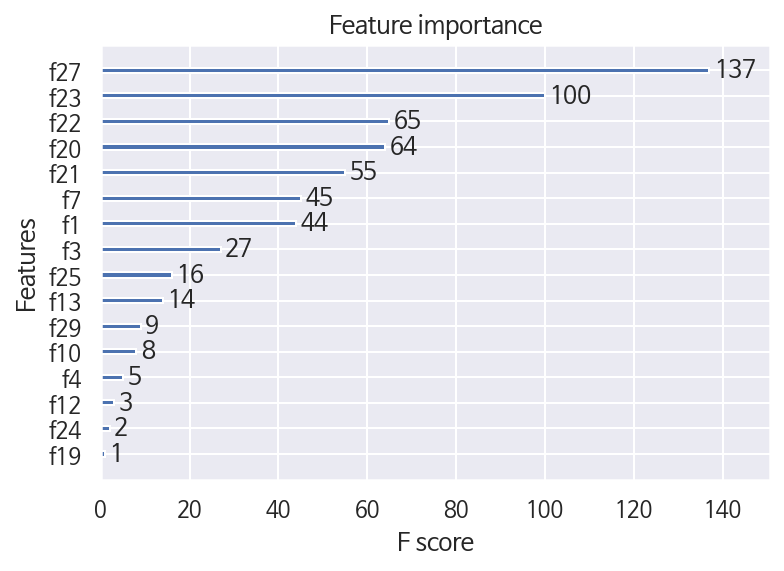

In [23]:
import matplotlib.pyplot as plt
plot_importance(xgb)
plt.show()

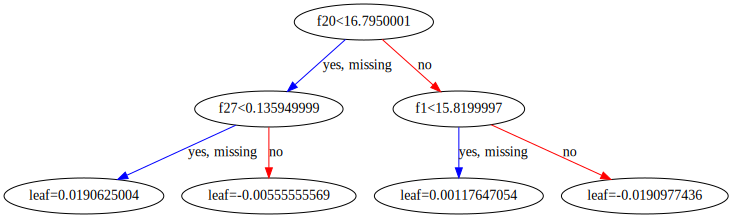

In [24]:
from xgboost import to_graphviz
to_graphviz(xgb)

### Light GBM

- XGBoost보다 빠르다 
- 트리의 균형을 맞추지 않고 최대 손실 값을 갖는 리프 노드를 지속적으로 분할하며 비대칭적 트리 생성
- 대용량 데이터 처리 가능! 용량이 부족하거나 데이터가 많을 때 유용
- 성능은 비슷하다

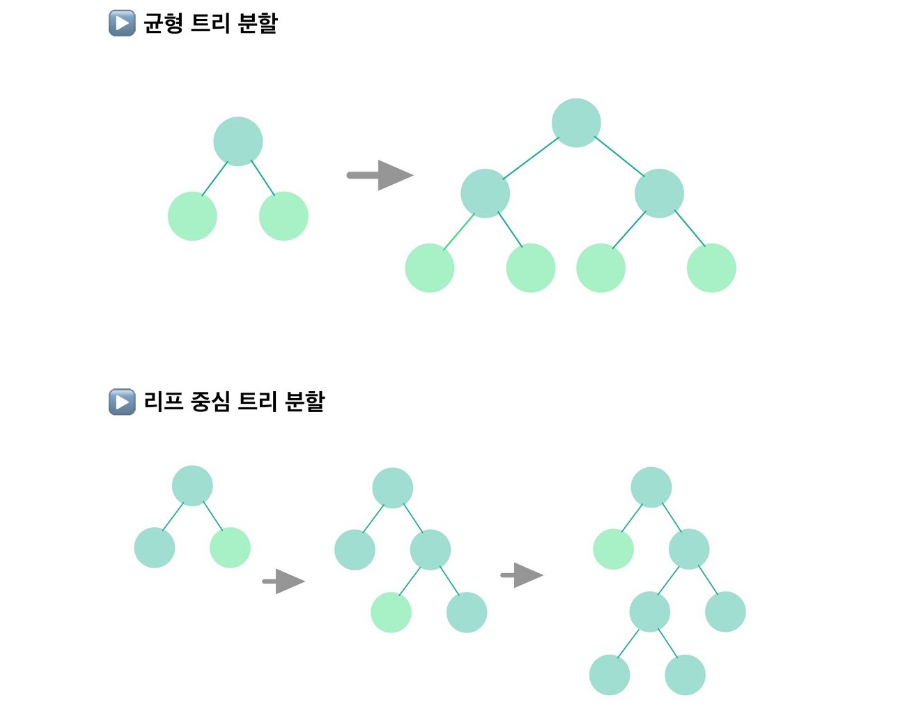



#### 주요 파라미터
- num_leaves : 클수록 정확도는 높아지지만 오버피팅 발생 가능
- min_data_in_leaf : 클수록 오버피팅 방지
- max_depth : 낮추기
- learning_rate 낯추기 & n_estimators 높이기

In [25]:
from lightgbm import LGBMClassifier, plot_importance

In [26]:
hp = {
    'random_state' : 42
}

In [28]:
lgb = LGBMClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {lgb.score(X_tr, y_tr)} / 학습용 평가지표 : {lgb.score(X_te, y_te)}')

훈련용 평가지표 : 1.0 / 학습용 평가지표 : 0.965034965034965


In [31]:
hp = {
    'random_state' : 42,
    'max_depth' : 2,
    'n_estimators' : 100,
    'learning_rate' : 0.01
} 


In [32]:
lgb = LGBMClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {lgb.score(X_tr, y_tr)} / 테스트용 평가지표 : {lgb.score(X_te, y_te)}')

훈련용 평가지표 : 0.9694835680751174 / 테스트용 평가지표 : 0.9440559440559441


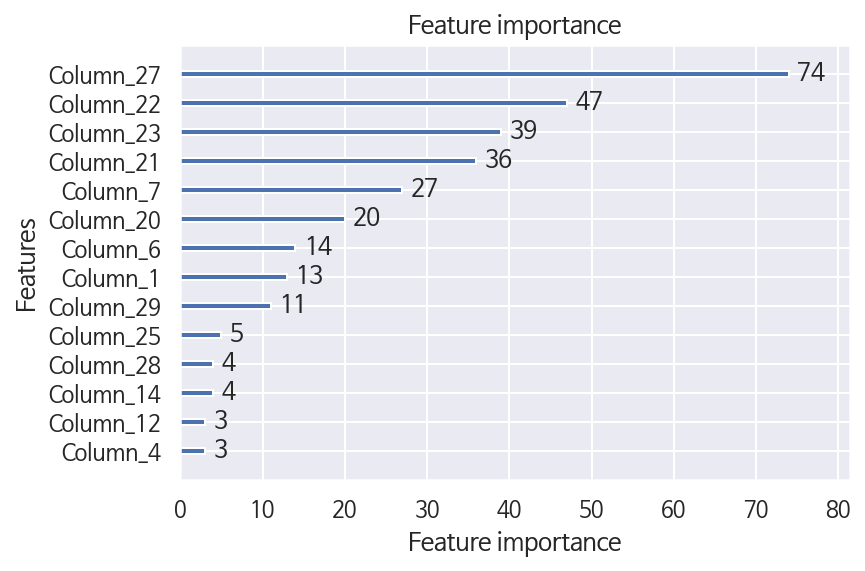

In [34]:
plot_importance(lgb)
plt.show()

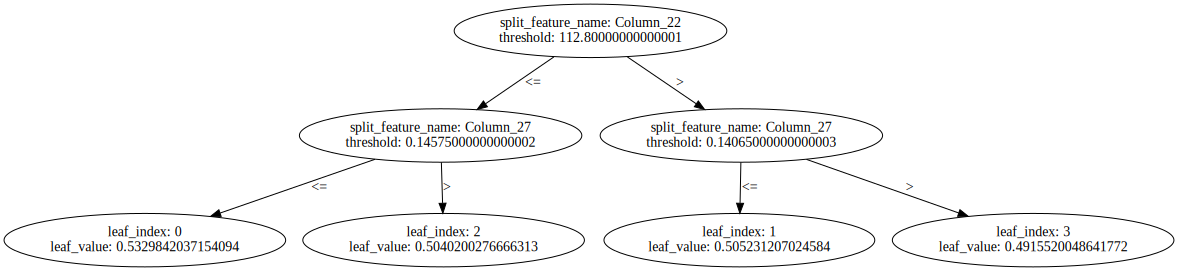

In [37]:
from lightgbm import create_tree_digraph
create_tree_digraph(lgb)

### Catboost
- 범주형 변수가 많을 경우 빠른 학습 속도를 제공한다.
- 수치형 변수가 많을 때 느리다.

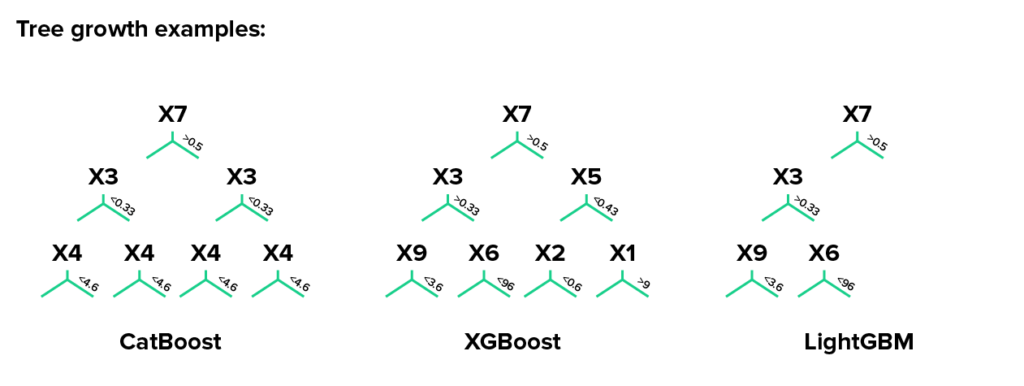

In [38]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.2 MB/s eta 0:00:00


In [39]:
from catboost import CatBoostClassifier

In [42]:
hp = {
    'random_state' : 42,
    'verbose' : 0 # 학습한 로그 데이터를 보여주지 않도록 설정
}

In [44]:
cat = CatBoostClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {cat.score(X_tr, y_tr)} / 테스트용 평가지표 : {cat.score(X_te, y_te)}')

훈련용 평가지표 : 1.0 / 테스트용 평가지표 : 0.965034965034965


In [45]:
hp = {
    'random_state' : 42,
    'max_depth' : 2,
    'n_estimators' : 100,
    'verbose' : 0
}

In [47]:
cat = CatBoostClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {cat.score(X_tr, y_tr)} / 테스트용 평가지표 : {cat.score(X_te, y_te)} ')

훈련용 평가지표 : 0.9882629107981221 / 테스트용 평가지표 : 0.965034965034965 


## Voting
> 다른 종류의 모델들의 예측값을 합쳐 최종 결과를 도출
- 각 모델들의 알고리즘이 모두 다름
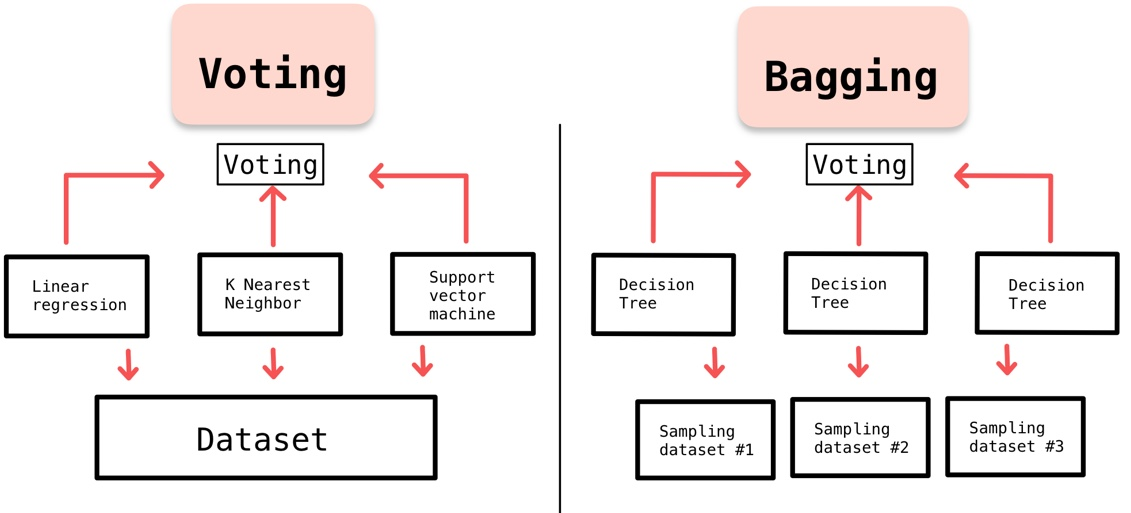

- Hard voting
  - 모델들의 예측 결과값을 다수결로 최종 class 결정

- Soft voting
  - 모델들의 예측 결과값간 확률을 평균하여 결정


  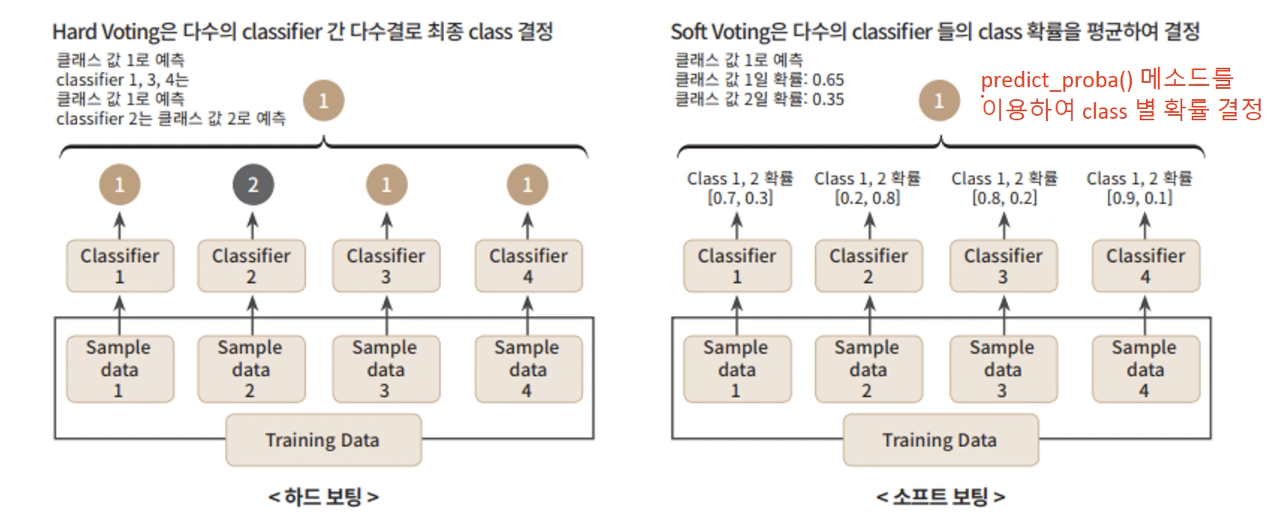

In [48]:
from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [49]:
SEED = 42
estimators = {
    ('mlp', MLPClassifier(max_iter=1000, random_state=SEED)),
    ('lr', LogisticRegression(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
}

In [50]:
hp = {
    'estimators' : estimators,
    'voting' : 'soft'
}

In [52]:
vot = VotingClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {vot.score(X_tr, y_tr)} / 테스트용 평가지표 : {vot.score(X_te, y_te)}')

훈련용 평가지표 : 0.971830985915493 / 테스트용 평가지표 : 0.951048951048951


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
hp = {
    'estimators' : estimators,
    'voting' : 'hard'
 }

In [55]:
vot = VotingClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {vot.score(X_tr, y_tr)} / 테스트용 평가지표 : {vot.score(X_te, y_te)}')

훈련용 평가지표 : 0.9647887323943662 / 테스트용 평가지표 : 0.9440559440559441


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Stacking
- 개별 모델의 학습 결과를 바탕으로 새로운 모델을 만들어 new learner model을 생성

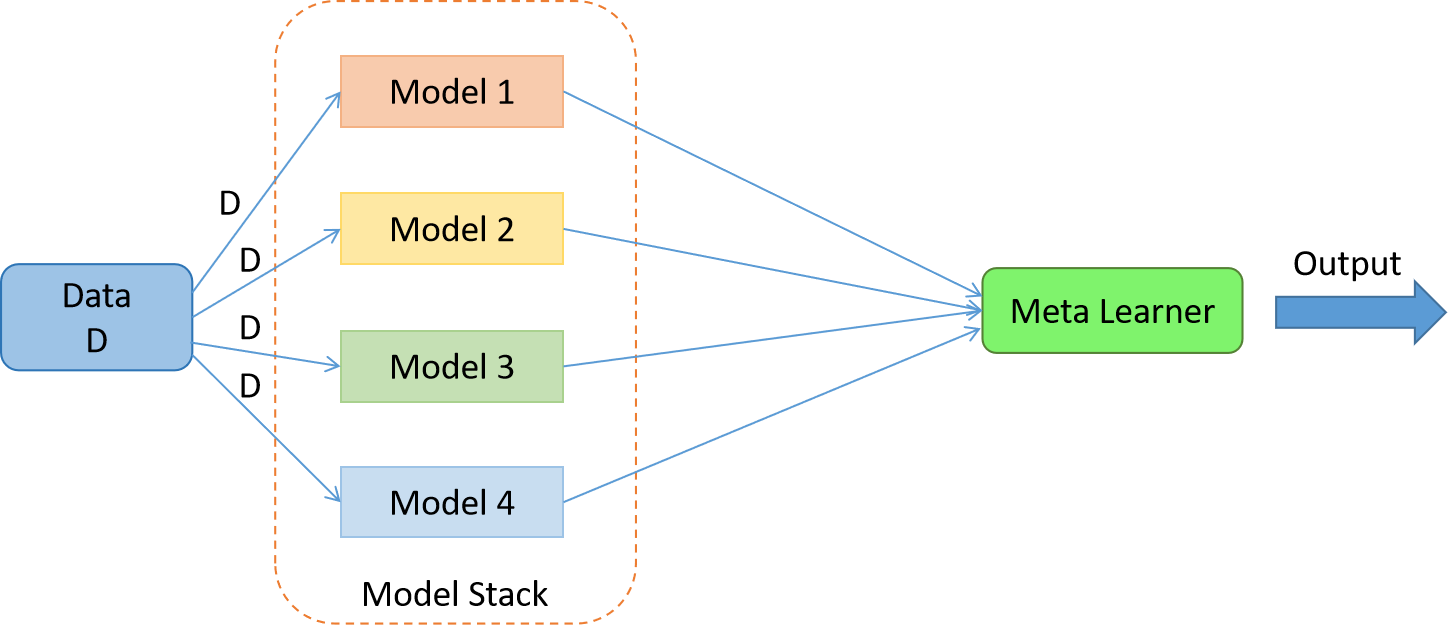

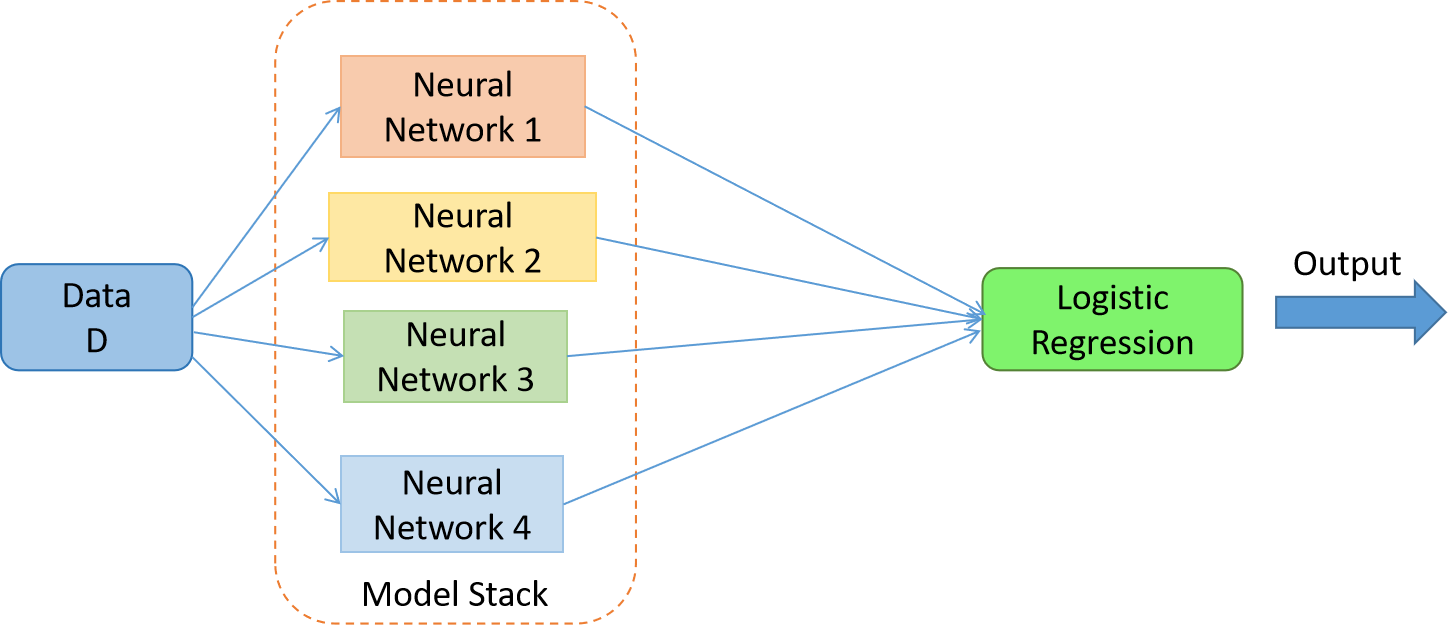

In [56]:
from sklearn.ensemble import StackingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [57]:
SEED = 42

estimators = {
    ('mlp', MLPClassifier(max_iter=1000, random_state=SEED)),
    ('lr', LogisticRegression(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
}

In [62]:
hp = {
    'estimators' : estimators,
    'final_estimator' : LogisticRegression(random_state=SEED)
}

In [63]:
stack = StackingClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표 : {stack.score(X_tr, y_tr)} / 테스트용 평가지표 : {stack.score(X_te, y_te)}')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

훈련용 평가지표 : 0.9812206572769953 / 테스트용 평가지표 : 0.958041958041958
